# Logistic Regression

## References

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

## Import Python Libraries

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Import Dataset

In [312]:
# Source: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: age
# X02: sex
# X03: chest pain type (4 values)
# X04: resting blood pressure
# X05: serum cholestoral in mg/dl
# X06: fasting blood sugar > 120 mg/dl
# X07: resting electrocardiographic results (values 0,1,2)
# X08: maximum heart rate achieved
# X09: exercise induced angina
# X10: oldpeak = ST depression induced by exercise relative to rest
# X11: the slope of the peak exercise ST segment
# X12: number of major vessels (0-3) colored by flourosopy
# X13: thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
#   Y: target: presence of heart disease, 0 = no disease and 1 = disease.

In [313]:
# load heart.csv dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/heart.csv'
df1 = pd.read_csv(filepath1, header = 0)
df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [314]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [315]:
# describe data
df1.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [316]:
# check missing values
df1.count()

age         1025
sex         1025
cp          1025
trestbps    1025
chol        1025
fbs         1025
restecg     1025
thalach     1025
exang       1025
oldpeak     1025
slope       1025
ca          1025
thal        1025
target      1025
dtype: int64

## Data Cleaning

Not Needed

## Transform Dataset

In [317]:
# user defined function to normalize data
def jra_znormalize(x):
  mu = np.mean(x)
  sigma = np.std(x)
  x = (x - mu) / sigma
  return(x)  

In [318]:
# response column
y_col = 'target'
y_col

'target'

In [319]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [320]:
# rename response labels
labels = {
  0: 'no disease',
  1: 'disease'
}
cond1 = df1[y_col] == 0
cond2 = df1[y_col] == 1
df1.loc[cond1, y_col] = labels[0]
df1.loc[cond2, y_col] = labels[1]

df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,no disease
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,no disease
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,no disease
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,no disease
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,no disease


In [321]:
labels[0]

'no disease'

In [322]:
# normalize all X_cols using z-score standardizaion (df2)
df2 = df1.copy()
df2[X_cols] = df1[X_cols].apply(jra_znormalize)
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,no disease
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,no disease
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,no disease
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,no disease
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,no disease


In [323]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [324]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = 'target',
  value_vars = X_cols,
  var_name = 'x',
  value_name = "x_value"
)
df3.head()

,target,x,x_value
0,no disease,age,-0.268437
1,no disease,age,-0.158157
2,no disease,age,1.716595
3,no disease,age,0.724079
4,no disease,age,0.834359


## Visualize Dataset

In [325]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols)
y_max = np.round(X.max().max(), 0)
y_min = np.round(X.min().min(), 0)

In [326]:
# subplot of y vs each X (boxplot + stripplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # sns.boxplot(ax = axes[row, col], data = df2, x = y_col, y = x)
  sns.boxplot(ax = axes[row, col], data = df2, x = y_col, y = x, palette = [(1, 1, 1), (1, 1, 1)])
  sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = [(1, 0, 0)], size = 1)
  axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

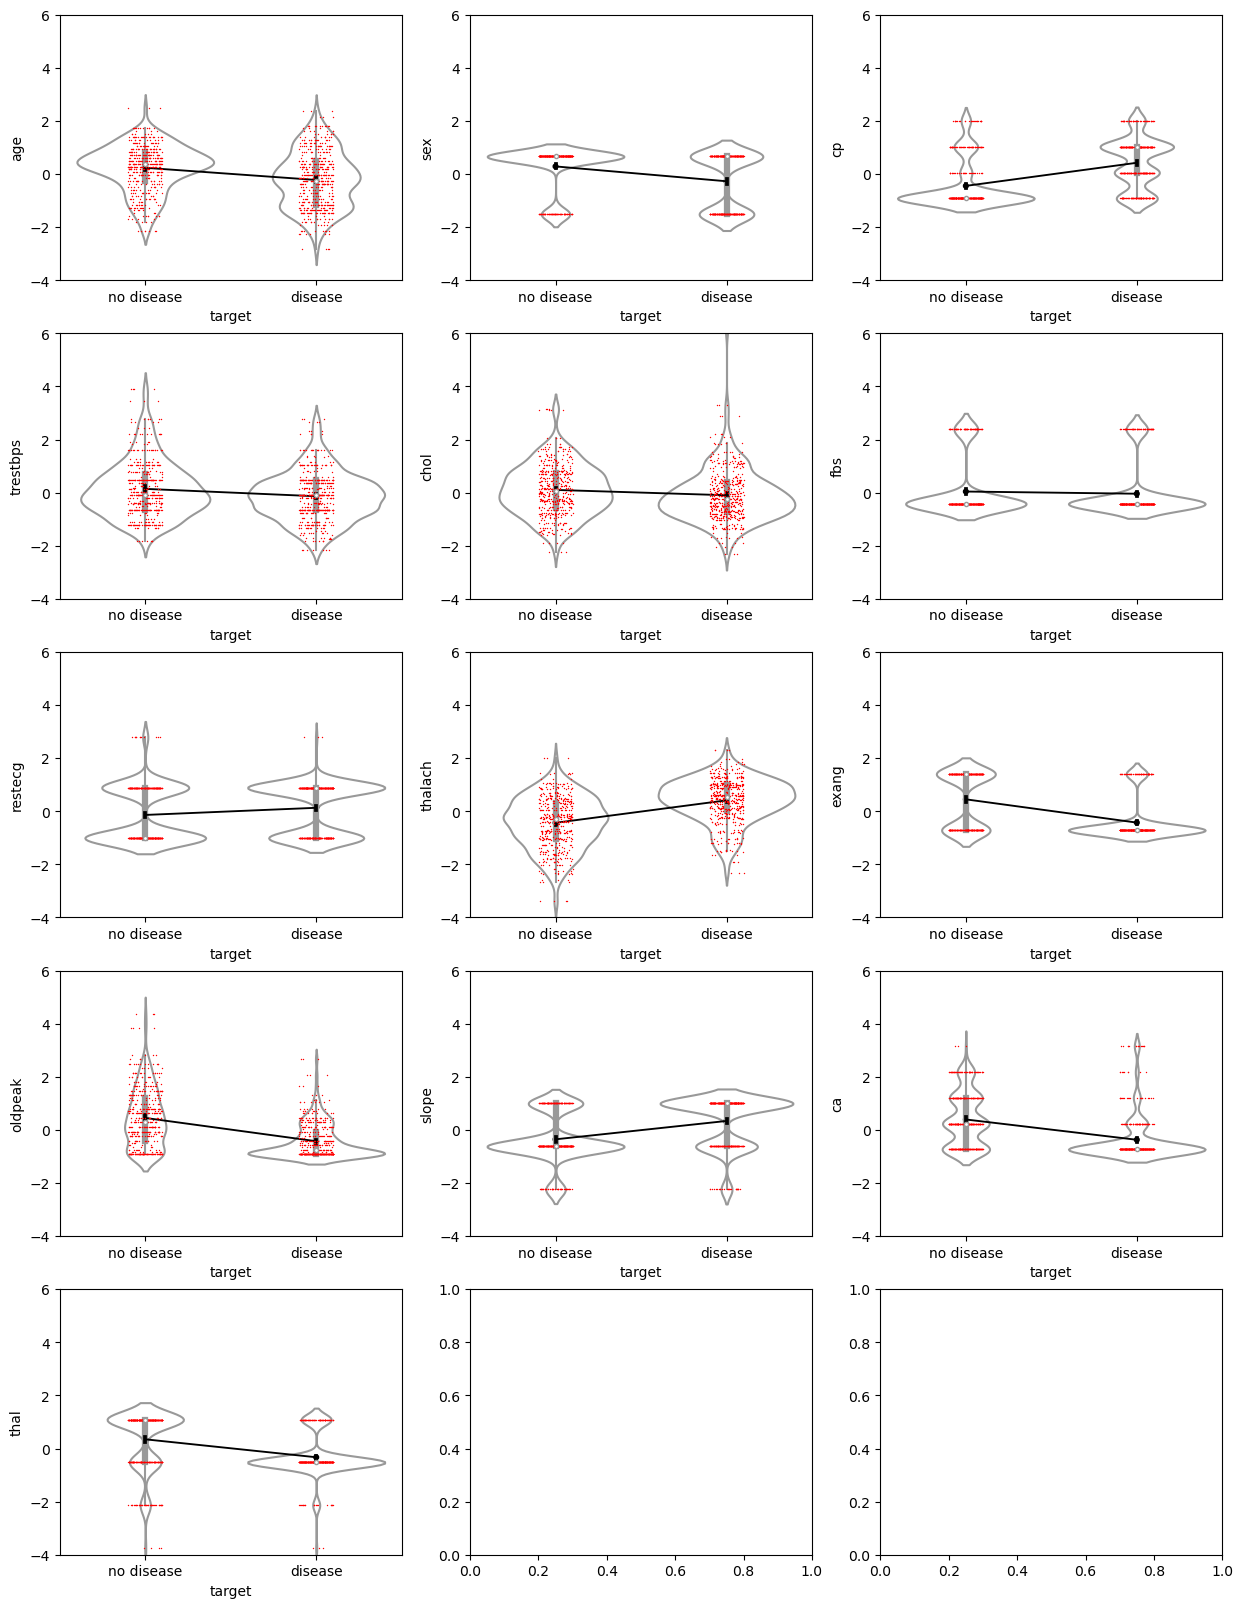

In [ ]:
# subplot of y vs each X (stripplot + violinplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = [(1, 0, 0)], size = 1)
  sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, palette = [(1, 1, 1), (1, 1, 1)])
  sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = (0, 0, 0), scale = 0.5)
  axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

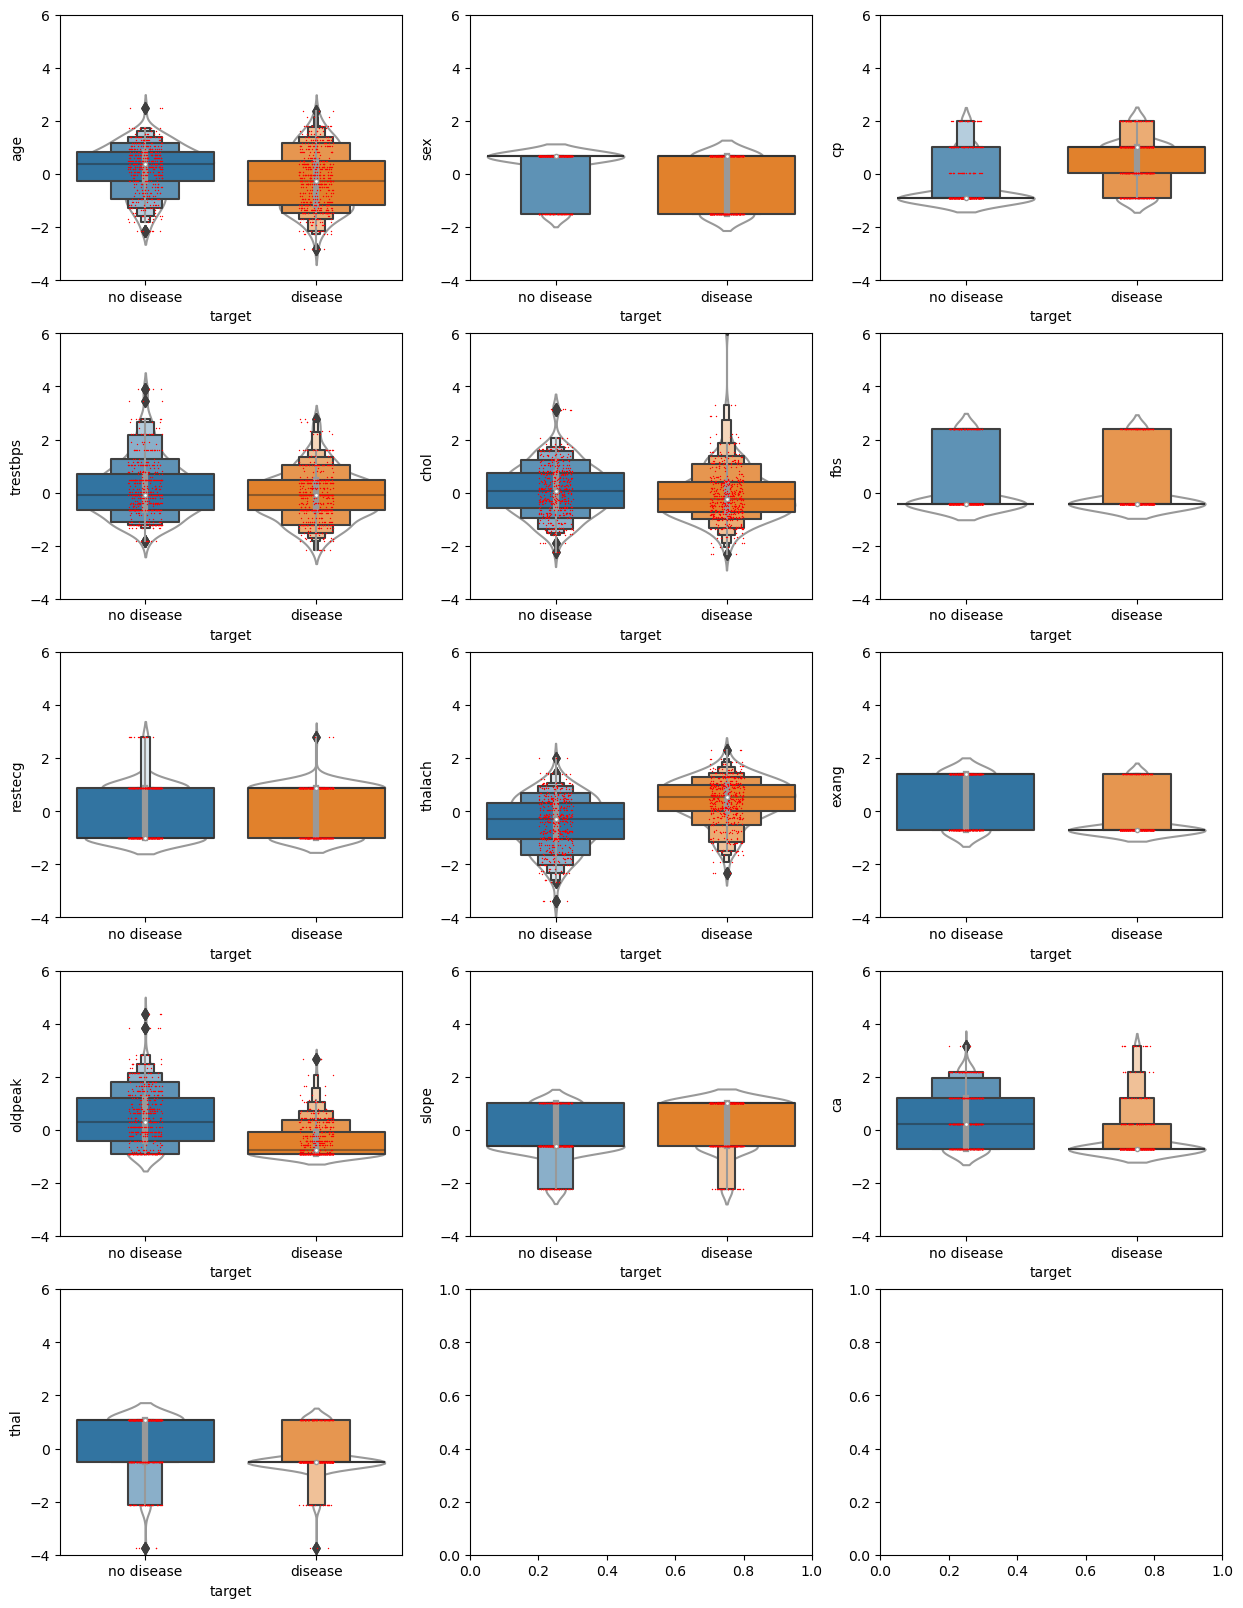

In [ ]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = [(1, 0, 0)], size = 1)
  sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, palette = [(1, 1, 1), (1, 1, 1)])
  sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x)
  axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Train and Test ML Model

In [ ]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# initialize logistic regression model
myfit = LogisticRegression(
  penalty = 'l2',
  fit_intercept = True,
  max_iter = 10000,
  random_state = 4781
)
# fit model
myfit.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=4781)

In [ ]:
# get predictions on test data
y_hat = myfit.predict(X_test)

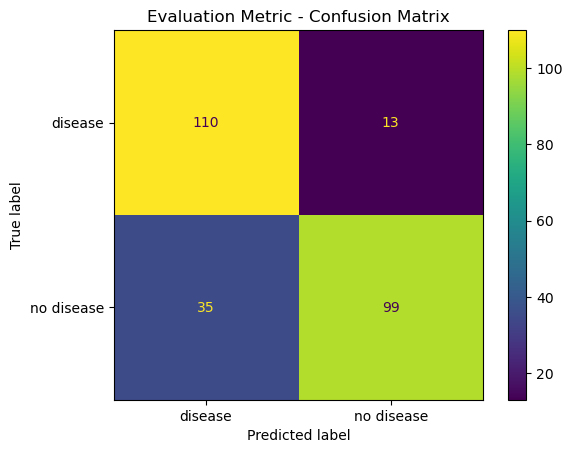

In [ ]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [ ]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False) 
print(metric_report)

              precision    recall  f1-score   support

     disease       0.76      0.89      0.82       123
  no disease       0.88      0.74      0.80       134

    accuracy                           0.81       257
   macro avg       0.82      0.82      0.81       257
weighted avg       0.82      0.81      0.81       257

